In [8]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/RelWithDebInfo')
sys.path.insert(0, '/home/sci/duong/Desktop/idx2/build/Source/Python')
sys.path.insert(0, 'D:/pascucci/ppt/2022/6_NASA/idx2/build/Source/Python/RelWithDebInfo')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from ipywidgets import *
import concurrent.futures

%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

vmin = -10
vmax = 10

C:\Users\Vlaerio's PC\AppData\Local\Temp\ipykernel_3348\1862283412.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Set up color map

In [9]:
import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

[0.0, 0.39072399999999996, 0.4869993, 0.500351358, 0.5186225999999999, 0.5354884, 1.0]


# Some helper functions

In [10]:
def get_file_name(input_dir, dataset, field, face, depth, time_from, time_to):
  return input_dir + '/' + dataset + '/' + field + '-face-' + repr(face) + '-depth-' + repr(depth) + '-time-' + repr(time_from) + '-' + repr(time_to) + '.idx2' 

def get_extent(dataset, face):
  if dataset == 'llc4320':
    if (face < 2):
      return (0, 0, 4320, 12960)
    elif (face > 2):
      return (0, 0, 12960, 4320)
    return (0, 0, 4320, 4320)
  elif dataset == 'llc2160':
    if (face < 2):
      return (0, 0, 2160, 6480)
    elif (face > 2):
      return (0, 0, 6480, 2160)
    return (0, 0, 2160, 2160)

# Query 
# extent should be a 4-tuple: (from_x, from_y, dim_x, dim_y)
def query_data(input_dir, dataset, times_per_file, times_per_brick, field, face, depth, time, downsampling, accuracy, extent=None):
  # determine the time step range to query from
  file_time_from    = (time // times_per_file) * times_per_file
  file_time_to      = file_time_from + times_per_file
  time_in_file      = time % times_per_file
  time_extent_from  = (time_in_file // times_per_brick) * times_per_brick
  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e0 = extent
  e1 = (e0[0]           , e0[1]           , e0[2]//2   , e0[3]//2   )
  e2 = (e0[0]+(e0[2]//2), e0[1]           , e0[2]-e1[2], e0[3]//2   )
  e3 = (e0[0]           , e0[1]+(e0[3]//2), e0[2]//2   , e0[3]-e1[3])
  e4 = (e0[0]+(e0[2]//2), e0[1]+(e0[3]//2), e0[2]-e1[2], e0[3]-e1[3])
  e1 = (e1[0], e1[1], time_extent_from, e1[2], e1[3], times_per_brick)
  e2 = (e2[0], e2[1], time_extent_from, e2[2], e2[3], times_per_brick)
  e3 = (e3[0], e3[1], time_extent_from, e3[2], e3[3], times_per_brick)
  e4 = (e4[0], e4[1], time_extent_from, e4[2], e4[3], times_per_brick)

  file = get_file_name(input_dir, dataset, field, face, depth, file_time_from, file_time_to)
  print(file)
    
  array = None
  if extent[2] < 16 or extent[3] < 16: # if too small, don't spawn threads
    e = (extent[0], extent[1], time_extent_from, extent[2], extent[3], times_per_brick)
    array = i2p.DecodeExtent3f32(file, input_dir, extent, downsampling, accuracy)
  else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
      f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
      f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
      f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
      f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
      a1 = f1.result()
      a2 = f2.result()
      a3 = f3.result()
      a4 = f4.result()
      shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
      array = np.empty(shape)

      array[:, :a1.shape[1], :a1.shape[2]] = a1
      array[:, :a2.shape[1], a1.shape[2]:] = a2
      array[:, a1.shape[1]:, :a3.shape[2]] = a3
      array[:, a1.shape[1]:, a3.shape[2]:] = a4
  
  return array

# Introducing the data

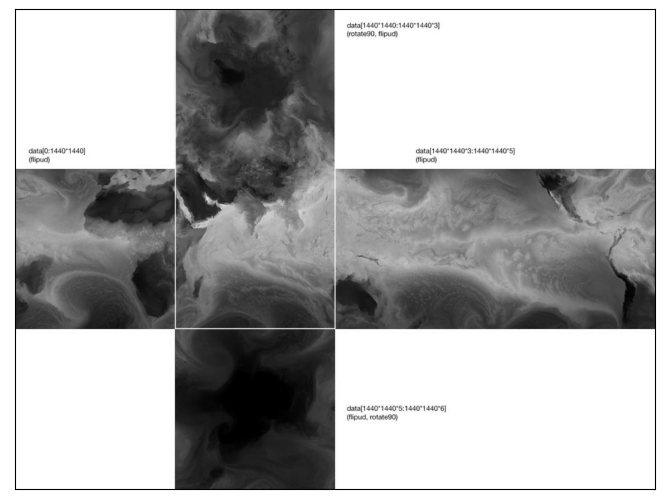

In [11]:
%matplotlib inline

import os
pathPrefix = 'J:/nasa/'
if not os.path.exists (pathPrefix): 
    pathPrefix = "W:/cedmav/hello/"

ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
img = mpimg.imread(pathPrefix+'MITgcm_lat_lon_cap_facets.png')
ax.imshow(img)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.show()

# Visualize a single face through time for llc2160 (32 time steps)

W:/cedmav/hello/llc2160_32/llc2160/u-face-0-depth-0-time-0-32.idx2


<IPython.core.display.Javascript object>


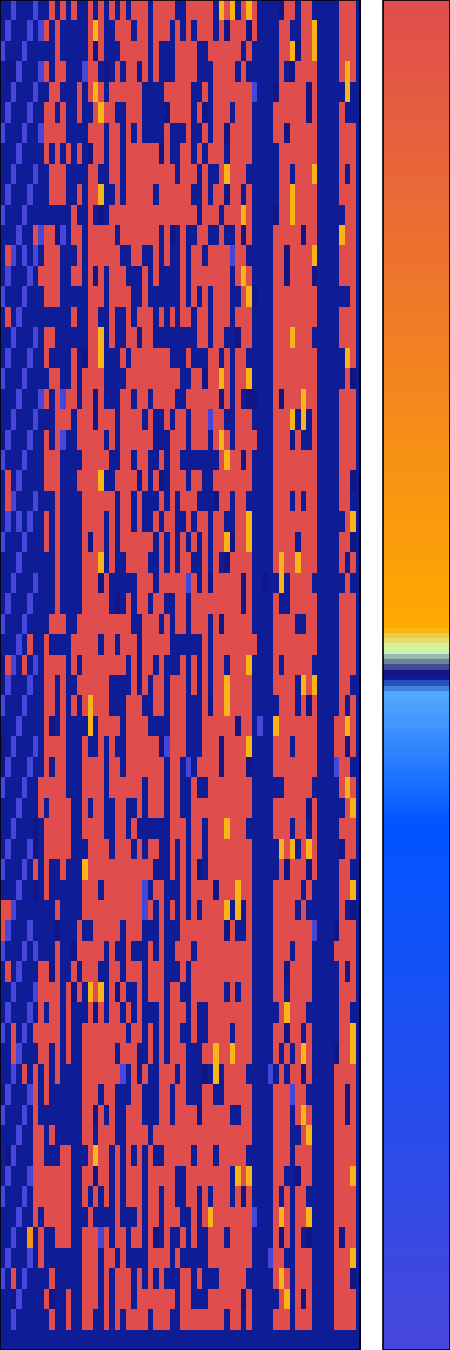

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='500px'), max=31), Output()), _d…

interactive(children=(IntSlider(value=0, description='f', layout=Layout(width='400px'), max=4), Output()), _do…

interactive(children=(IntSlider(value=0, description='d', layout=Layout(width='1000px'), max=89), Output()), _…

In [12]:
%matplotlib notebook
def test1():
  input_dir = pathPrefix+'llc2160_32'
  dataset = 'llc2160'
  times_per_file = 32
  times_per_brick = 32
  face = 0
  depth = 0
  time = 0
  accuracy = 0.1
  downsampling = [2, 2, 2]

  plt.close()
   
  time_block = 0
  array = np.empty((1,1,1))
  array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, time, downsampling, accuracy)

  fig = plt.figure(figsize = (3, 9))
  plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.colorbar(plot)
  #plt.margins(0,0)
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
  first_draw = True
  first_query = 2

  def display():
    nonlocal face, plot, fig
    if face == 2:
      fig.set_size_inches(3, 3)
    else:
      fig.set_size_inches(3, 9)
    if face <= 2:
      plot = plt.imshow(array[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
    else:
      plot = plt.imshow(np.rot90(array[0, :, :]), origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  
  def change_face(f):
    nonlocal face, array, first_query
    if first_query > 0:
      first_query = first_query - 1
      return
    face = f
    ds = (2, 2, 2)
    array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, time, ds, accuracy)
    display()
  
  def change_depth(d):
    nonlocal depth, array, plot, fig, first_query
    if first_query > 0:
      first_query = first_query - 1
      return
    depth = d
    ds = (2, 2, 3)
    array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, time, ds, accuracy)
    display()
  
  def f(t):
    nonlocal time_block
    nonlocal array
    nonlocal first_draw

    curr_time_block = t // times_per_brick
    if curr_time_block != time_block:        
      ds = (2, 2, 0)
      array = query_data(input_dir, dataset, times_per_file, times_per_brick, 'u', face, depth, t, ds, accuracy)
      time_block = curr_time_block
    tt = min((t - time_block * times_per_brick) // pow(2, downsampling[2]), array.shape[0]-1)
    if face <= 2:
      plot.set_data(array[tt,:,:])
    else:
      plot.set_data(np.rot90(array[tt,:,:]))
    if first_draw:
      first_draw = False
      fig.canvas.draw_idle()

    plt.show()
    return

  interact(f, t = widgets.IntSlider(min=0, max=31, step=1, value=0, layout=Layout(width='500px')));
  interact(change_face, f = widgets.IntSlider(min=0, max=4, step=1, value=0, layout=Layout(width='400px')));
  interact(change_depth, d = widgets.IntSlider(min=0, max=89, step=1, value=0, layout=Layout(width='1000px')));

test1()